In [29]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression as LinearRegression

# Add the src directory t\ the Python path

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# Now you can import the TimeSeriesDataset class
from src.TimeSeriesDataset import TimeSeriesDataset as TSD
from src.utils import download_data, weighted_mean
from src.mappings import value_mapping, ideology_mapping, social_complexity_mapping

In [2]:
dataset = TSD(categories=['sc'], file_path="../datasets/power_transitions.csv")
dataset.scv_imputed = pd.DataFrame()


Dataset loaded from ../datasets/power_transitions.xlsx


In [4]:
imp_columns =  ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']
dataset.impute_missing_values(imp_columns, use_duplicates=False)
sc_columns = ['Pop','Cap','Terr','Hierarchy', 'Government', 'Infrastructure', 'Information', 'Money']

In [5]:
crisis_vars = ['overturn',
              'predecessor_assassination'
              ,'intra_elite'
              ,'military_revolt'
              ,'popular_uprising'
              ,'separatist_rebellion'
              ,'external_invasion'
              ,'external_interference'
              ]
for var in crisis_vars:
    dataset.scv_imputed[var] = dataset.raw[var]
dataset.scv_imputed.dropna(subset=imp_columns, inplace=True)

In [23]:
pca = dataset.compute_PCA(imp_columns, 'PC', n_cols = 2, n_PCA = 8, contributions=True, rescale = True)
dataset.scv_imputed['PC_1'] = 10 - dataset.scv_imputed['PC_1']

Explained variance by each PC:
PC1: 70.88%
PC2: 7.68%
PC3: 6.57%
PC4: 5.14%
PC5: 3.82%
PC6: 2.59%
PC7: 2.20%
PC8: 1.13%
PC1 contributions:
Pop: -0.38
Cap: -0.38
Terr: -0.36
Hierarchy: -0.32
Government: -0.36
Infrastructure: -0.34
Information: -0.34
Money: -0.34
PC1 contributions:
Pop: 0.27
Cap: 0.26
Terr: 0.18
Hierarchy: -0.03
Government: -0.06
Infrastructure: 0.43
Information: -0.60
Money: -0.53


<ErrorbarContainer object of 3 artists>

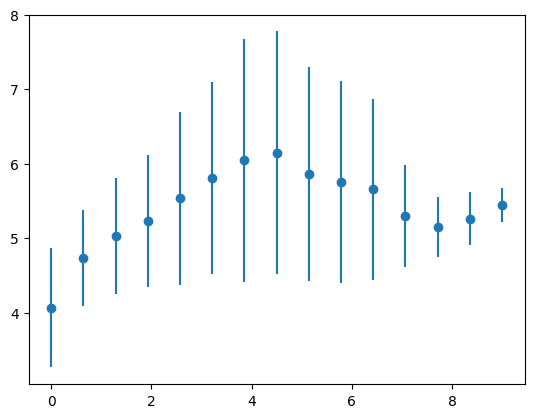

In [24]:
n_bins = 15
scv_imp = dataset.scv_imputed#.drop_duplicates(subset=imp_columns)
pc1 = np.linspace(scv_imp.PC_1.min(), scv_imp.PC_1.max(), n_bins)
delta = (pc1[1] - pc1[0])
pc2 = np.zeros(n_bins)
pc2_std = np.zeros(n_bins)

crisis = np.zeros((len(crisis_vars),n_bins))


for i in range(n_bins):
    pc2[i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-2*delta) & (scv_imp.PC_1 < pc1[i]+2*delta), 'PC_2'].dropna().mean()
    pc2_std[i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-2*delta) & (scv_imp.PC_1 < pc1[i]+2*delta), 'PC_2'].dropna().std()
    for v in range(len(crisis_vars)):
        crisis[v,i] = scv_imp.loc[(scv_imp.PC_1 >= pc1[i]-2*delta) & (scv_imp.PC_1 < pc1[i]+2*delta), crisis_vars[v]].dropna().mean()

plt.errorbar(pc1, pc2, yerr=pc2_std, fmt='o')

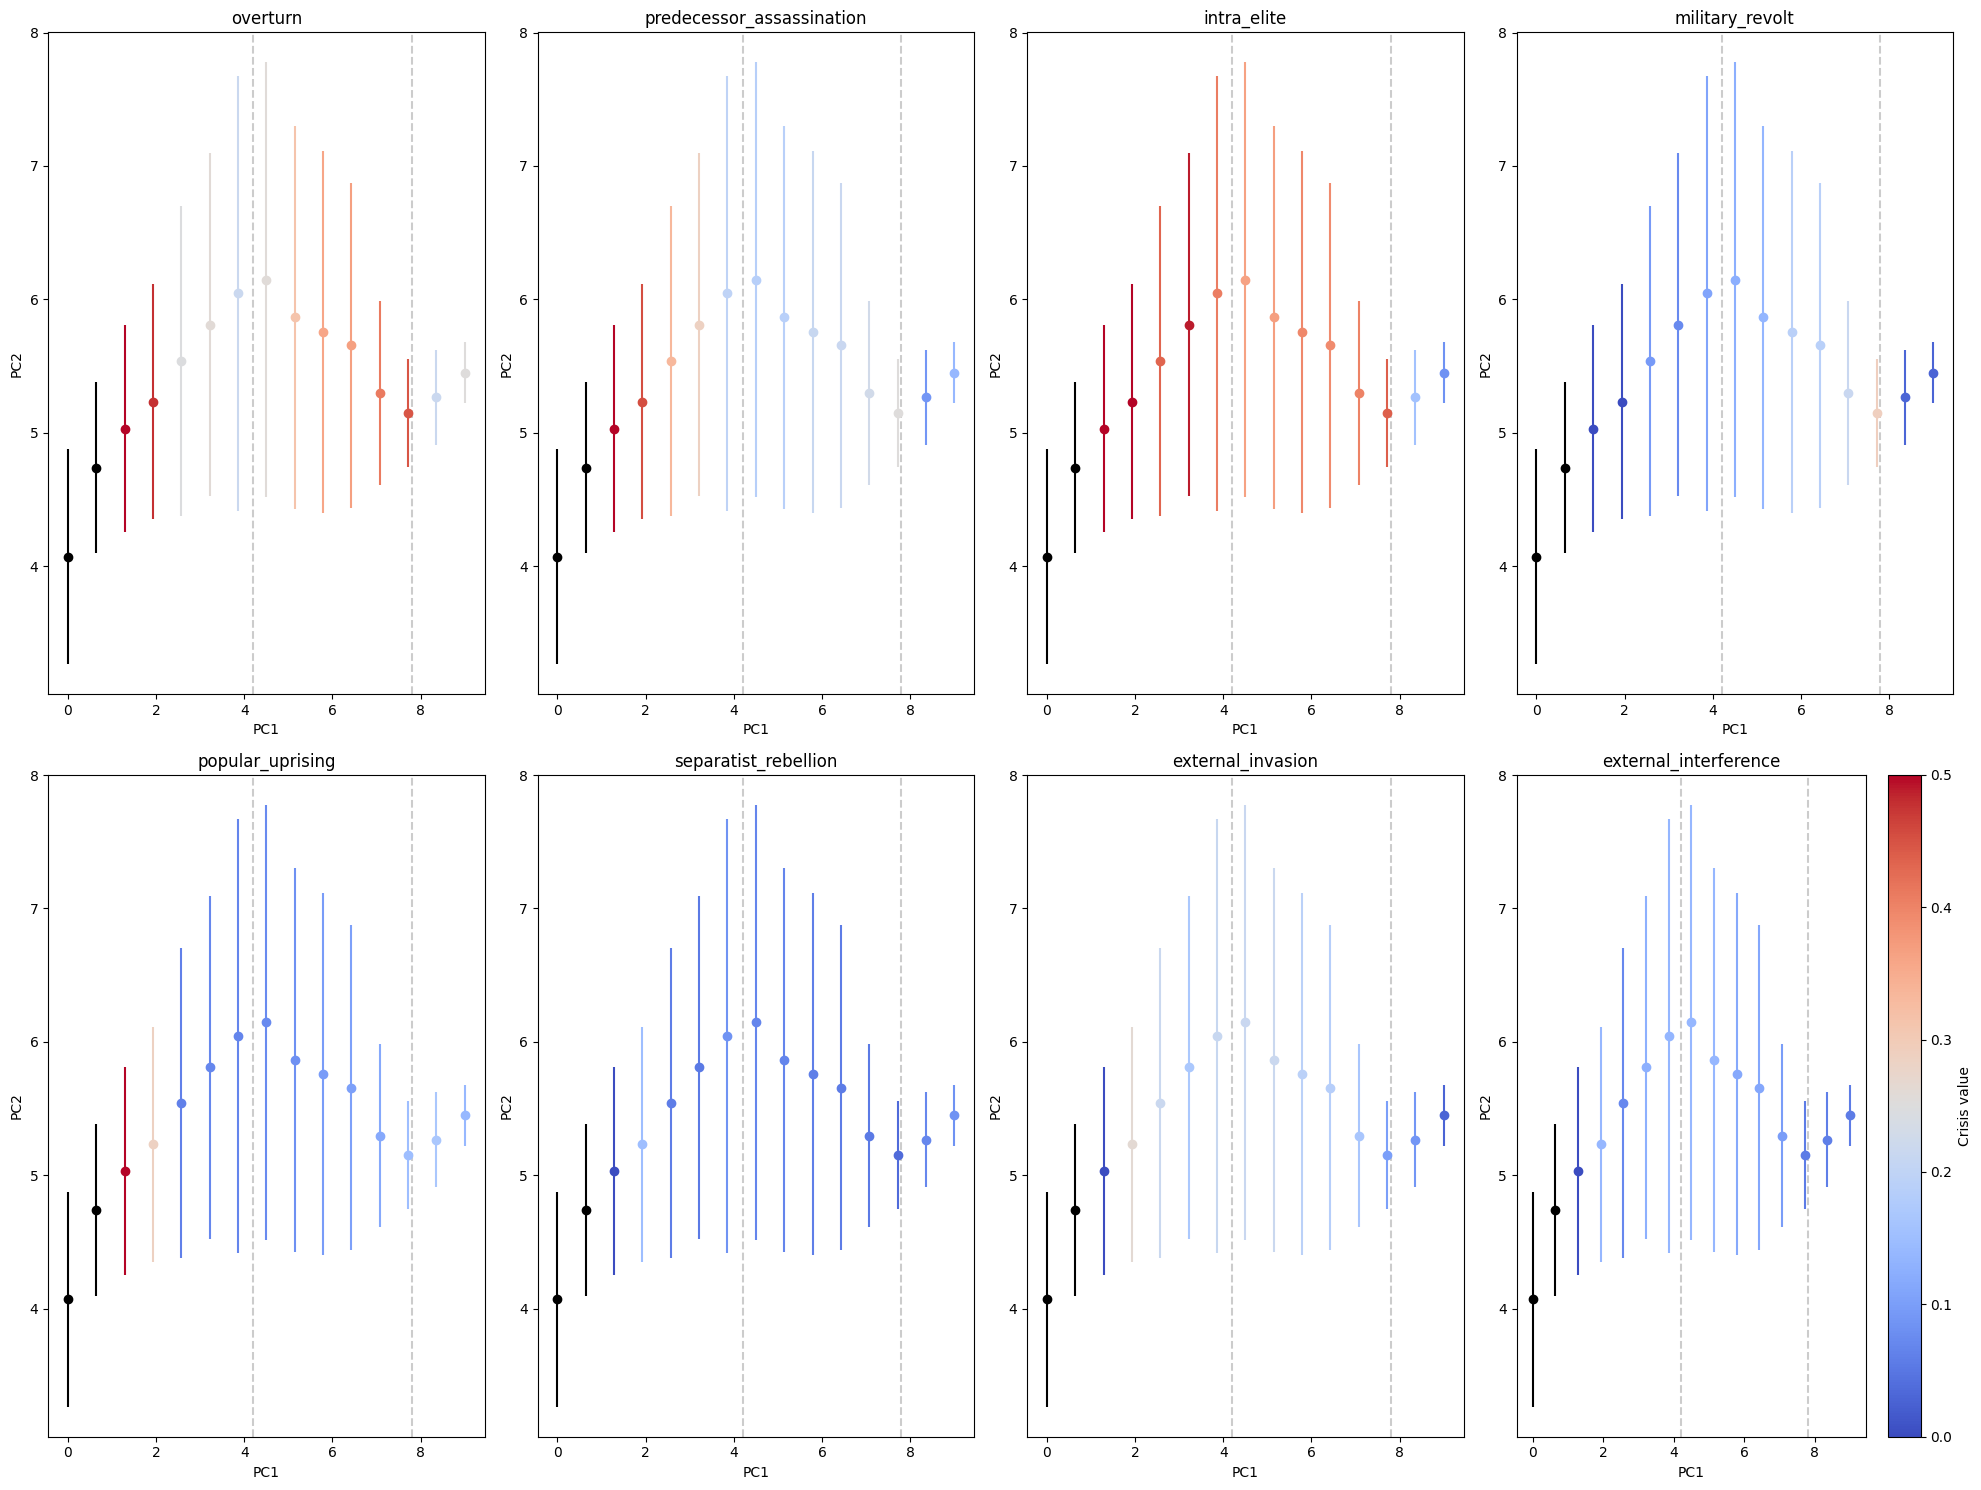

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(20, 15))
axes = axes.flatten()
vmax = 0.5
for v in range(len(crisis_vars)):
    # Normalize the crisis values to use with a colormap
    norm = crisis / crisis.max()
    cmap = plt.get_cmap('coolwarm')

    # Plot the error bars with colors based on the crisis values
    for i in range(len(pc1)):
        axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color=cmap(crisis[v, i] / vmax))
        if pd.isna(crisis[v, i]):
            axes[v].errorbar(pc1[i], pc2[i], yerr=pc2_std[i], fmt='o', color='black')
    axes[v].set_xlabel('PC1')
    axes[v].set_ylabel('PC2')
    axes[v].set_title(crisis_vars[v])
    vlines = [4.2,7.8]
    for vl in vlines:
        axes[v].axvline(vl, color='black', linestyle='--', alpha=0.2)

# Add a colorbar to the last axis
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(0, vmax))
sm.set_array([])
fig.colorbar(sm, ax=axes[-1], orientation='vertical', label='Crisis value')
plt.tight_layout()
plt.show()

In [47]:
scale_cols = ['Pop','Terr','Cap']
comp_mapping = {'Comp':{'Information': 0.6, 'Money':0.53}}
scale_mapping = {'Scale': {'Pop': 0.25, 'Cap': 0.26, 'Terr': 0.18, 'Infrastructure': 0.43}}
dataset.scv_imputed['Scale_1'] = dataset.scv_imputed.apply(lambda row: weighted_mean(row, scale_mapping, "Scale"), axis=1)

# rescale the PCA according to variable Pop
# Fit linear model to rescale the PCA according to variable Pop
lm_df = dataset.scv_imputed[['Pop', 'Scale_1']].dropna()
X = lm_df[['Pop']]
y = lm_df['Scale_1']

# Create and fit the model
model = LinearRegression()
model.fit(X, y)

# Extract the coefficients
intercept = model.intercept_
slope = model.coef_[0]

# Adjust the Scale_1 column
dataset.scv_imputed['Scale_1'] = (dataset.scv_imputed['Scale_1'] - intercept) / slope

dataset.scv_imputed['Comp'] = dataset.scv_imputed[['Information', 'Money']].apply(lambda row: weighted_mean(row, comp_mapping, "Comp"), axis=1)

miltech_mapping = {'Miltech':{'Metal': 1, 'Project': 1, 'Weapon':1, 'Armor': 1, 'Animal': 1, 'Defense': 1}}

dataset.scv['Miltech'] = dataset.scv.apply(lambda row: weighted_mean(row, miltech_mapping, "Miltech", imputation='remove'), axis=1)

dataset.scv['Miltech'] = dataset.scv[miltech_mapping.keys()].sum(axis=1)
dataset.scv['IronCav'] = dataset.scv.apply(lambda row: row["Iron"] + row["Cavalry"], axis=1)

In [51]:
import pyreadr
polity_df = download_data("https://seshatdata.com/api/core/polities/")

data = pyreadr.read_r("../datasets/TableData.Rdata")
df = data['ImpSCDat']
df_agri = data['AggrSCWarAgriRelig']

add_cols = ['Metal','Project','Weapon','Animal','Armor','Defense','Cavalry','Iron','Agri','AgriLag']
for col in add_cols:
    df[col] = df_agri[col]

col_replacements = {'Time': 'Year', 'Hier':'Hierarchy', 'Gov':'Government', 'Infra':'Infrastructure',
                    'Info': 'Information'}
df = df.rename(columns=col_replacements)
df['PolityName'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'new_name'].values[0] if x in polity_df['name'].values else x)
df['PolityID'] = df['PolID'].apply(lambda x: polity_df.loc[polity_df['name'] == x, 'id'].values[0] if x in polity_df['name'].values else x)
add_cols = ['Agri','AgriLag']
    # add cols to dataset by merging on PolityID and year from df_agri
for col in add_cols:
    dataset.scv = dataset.scv.merge(df[['PolityID','Year',col]], on=['PolityID','Year'], how='left')

transfer_cols = ['Agri','AgriLag','dataset','Miltech','IronCav']
for col in transfer_cols:
    dataset.scv_imputed[col] = dataset.scv[col]

Downloaded 839 rows


/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_86894/1232810737.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  dataset.scv = dataset.scv.merge(df[['PolityID','Year',col]], on=['PolityID','Year'], how='left')
/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_86894/1232810737.py:20: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation.
  dataset.scv = dataset.scv.merge(df[['PolityID','Year',col]], on=['PolityID','Year'], how='left')


In [52]:
dr = dataset.scv_imputed[dataset.scv_imputed.dataset == '100y'].copy()

# remove rows without NGA value
dr = dr.dropna(subset=['NGA'])
dr['PC1_t'] = np.nan
dr['d_Scale'] = np.nan
dr['Comp_t'] = np.nan
dr['d_Comp'] = np.nan


dr_nga = dr.groupby('NGA')
for nga, group in dr_nga:
    group = group.sort_values(['Year', 'PolityID'])
    group.drop_duplicates(subset = ['Year'], keep = 'first', inplace = True)

    # find values 100 years later
    dr.loc[group.index, 'Scale_t'] = group['Scale_1'].shift(-1).values
    dr.loc[group.index, 'Comp_t'] = group['Comp'].shift(-1).values
    dr.loc[group.index, 'd_Scale'] = dr.loc[group.index, 'Scale_t'] - group['Scale_1']
    dr.loc[group.index, 'd_Comp'] = dr.loc[group.index, 'Comp_t'] - group['Comp']
    # remove rows without a value 100 yrs later
    mask = (group['Year'] - group['Year'].shift(-1) != -100)
    indices = group.index.intersection(mask[mask].index)

    dr.loc[indices,'Scale_t'] = np.nan
    dr.loc[indices,'Comp_t'] = np.nan
    dr.loc[indices,'d_Scale'] = np.nan
    dr.loc[indices,'d_Comp'] = np.nan

In [54]:
import statsmodels.api as sm
x_cols = ['Scale_1','Scale_sq','Agri','AgriLag','IronCav', 'Comp']
y_col = ['Scale_t']
Xy = dr
Xy['Scale_sq'] = Xy['Scale_1']**2
Xy = Xy[y_col+x_cols].dropna()

Xy['intercept'] = 1
X = Xy[x_cols+ ['intercept']]
X.drop(columns=['Comp'], inplace=True)
y = Xy[y_col]

model = sm.OLS(y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Scale_t   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     3362.
Date:                Tue, 04 Mar 2025   Prob (F-statistic):               0.00
Time:                        13:08:51   Log-Likelihood:                -290.48
No. Observations:                 853   AIC:                             591.0
Df Residuals:                     848   BIC:                             614.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Scale_1        1.0102      0.063     16.048      0.0

/var/folders/c3/82t48qlj2bg0xttc4k7vx70r0000gq/T/ipykernel_86894/3194157670.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['Comp'], inplace=True)
